In [1]:
#import libraries
#!conda install beauifulsoup4 --yes
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install requests

In [2]:
import numpy as np 
import pandas as pd
import requests
from bs4 import BeautifulSoup

## Data Scraping of Washington D.C. 

In [3]:
#Scrape the desired url for the data of interest
url = "https://commons.wikimedia.org/wiki/Category:Neighborhoods_in_Washington,_D.C."
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
#print(soup.prettify())
content = soup.find(class_='mw-category')
content_list = content.find_all('a', href=True)

In [4]:
#Extract the neighborhoods' names and clean off all the excess symbols
df_list=[]
for link in content_list:
    href = link['href']
    if 'Category' in href:
        df_list.append(href)
df_mess = pd.DataFrame(df_list,columns=["neighborhood"])
df_mess = df_mess["neighborhood"].replace({'/wiki/Category:':''}, regex=True)
df_mess = pd.DataFrame(df_mess,columns=["neighborhood"])
df_mess = df_mess["neighborhood"].replace({'_':' '}, regex=True)
df_mess = pd.DataFrame(df_mess,columns=["neighborhood"])
df_mess = df_mess["neighborhood"].replace({'Washington, D.C.':''}, regex=True)
df_mess = pd.DataFrame(df_mess,columns=["neighborhood"])
df_mess = df_mess["neighborhood"].replace({'[(),,]':''}, regex=True)
df = pd.DataFrame(df_mess,columns=["neighborhood"])
df = df.drop(index=0,axis=0)
df.head(10)

,neighborhood
1,Adams Morgan
2,Anacostia
3,Barney Circle
4,Barry Farm
5,Benning Ridge
6,Berkley
7,Blagden Alley-Naylor Court Historic District
8,Bloomingdale
9,Brightwood
10,Brookland


In [5]:
#Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
geolocator = Nominatim(user_agent="DC_explorer")

df['search']= (df['neighborhood']+", Washington, D.C.").apply(geolocator.geocode)

#A handful of neighborhoods did not return coordinates so we will drop them for the sake of the experiment
nan_value = float("NaN")
df.replace("None", nan_value, inplace=True)
df.dropna(subset = ["search"], inplace=True)

df['search'].apply(lambda x: (x.latitude, x.longitude))
df[['point', 'coords']] = df['search'].apply(pd.Series)
df.drop(['search'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,neighborhood,point,coords
0,Adams Morgan,"Adams Morgan, Washington, District of Columbia...","(38.9215002, -77.0421992)"
1,Anacostia,"Anacostia, Washington, District of Columbia, U...","(38.8625806, -76.98444095341674)"
2,Barry Farm,"Barry Farm, Washington, District of Columbia, ...","(38.8598039, -76.9969706)"
3,Benning Ridge,"Benning Ridge, Washington, District of Columbi...","(38.88135145, -76.93863030975535)"
4,Bloomingdale,"Bloomingdale, Washington, District of Columbia...","(38.9167782, -77.0113652)"


In [6]:
#split the coordinates into their perspective lat and long columns and add to the main DataFrame
df_coords = pd.DataFrame(df['coords'].tolist(), index=df.index, columns=['latitude','longitude'])
df_DC = pd.concat([df, df_coords], axis=1)
df_DC.drop('coords', axis=1, inplace=True)
df_DC

,neighborhood,point,latitude,longitude
0,Adams Morgan,"Adams Morgan, Washington, District of Columbia...",38.921500,-77.042199
1,Anacostia,"Anacostia, Washington, District of Columbia, U...",38.862581,-76.984441
2,Barry Farm,"Barry Farm, Washington, District of Columbia, ...",38.859804,-76.996971
3,Benning Ridge,"Benning Ridge, Washington, District of Columbi...",38.881351,-76.938630
4,Bloomingdale,"Bloomingdale, Washington, District of Columbia...",38.916778,-77.011365
...,...,...,...,...
61,Truxton Circle,"Truxton Circle, Washington, District of Columb...",38.909834,-77.014976
62,University Heights,"University Heights, Washington, District of Co...",38.939314,-76.994316
63,West End,"West End, Washington, District of Columbia, Un...",38.907056,-77.049699
64,Woodley Park,"Woodley Park, Connecticut Avenue Northwest, Wo...",38.925025,-77.052363


## Clustering Washington D.C. Neighborhoods

In [7]:
#import required libraries
import json
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [8]:
#Start by obtaining the coordinates of Washington D.C. (Hereby known as DC)
location = geolocator.geocode('Washington D.C.')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Washington D.C. are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Washington D.C. are 38.8949924, -77.0365581.


In [9]:
#Visualize DC and it's neighborhoods using Lumium
DC_map = folium.Map(location=[latitude, longitude], zoom_start=11)

 # add markers to map
for lat, lng, label in zip(df_DC['latitude'], df_DC['longitude'], df_DC['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(DC_map) 
    
DC_map

In [31]:
# @hidden_cell
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XXX
CLIENT_SECRET:XXX


In [11]:
#Define a method to do the searching work for us
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

DC_venues = getNearbyVenues(names=df_DC['neighborhood'],
                                   latitudes=df_DC['latitude'],
                                   longitudes=df_DC['longitude']
                                  )

Adams Morgan
Anacostia
Barry Farm 
Benning Ridge
Bloomingdale 
Brightwood 
Brookland 
Burrville 
Buzzard Point
Capitol Hill 
Cathedral Heights 
Chevy Chase 
Chinatown 
Cleveland Park 
Columbia Heights 
Congress Heights
Crestwood 
Deanwood 
Downtown 
Dupont Circle
Eckington 
Edgewood 
Embassy Row 
Federal Triangle
Foggy Bottom
Forest Hills 
Fort Dupont 
Fort Totten 
Friendship Heights 
Gateway 
Georgetown 
Glover Park 
Golden Triangle 
Greenway 
Ivy City 
Judiciary Square
Kingman Park 
LeDroit Park
Logan Circle
Manor Park 
Marshall Heights 
Michigan Park 
Mount Pleasant 
Mount Vernon Square
Navy Yard 
Near Northeast 
NoMa 
North Cleveland Park 
The Palisades 
Park View 
Penn Quarter 
Petworth 
Pleasant Hill 
Randle Highlands
Shaw 
Shepherd Park 
Southwest Federal Center 
Southwest Waterfront 
Spring Valley 
Takoma 
Tenleytown 
Truxton Circle 
University Heights 
West End 
Woodley Park 
Woodridge 


In [12]:
DC_restaurants = DC_venues[DC_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
DC_restaurants.index = np.arange(1, len(DC_restaurants )+1)
print (DC_restaurants['Venue Category'].value_counts())

American Restaurant                28
Italian Restaurant                 22
Mexican Restaurant                 22
Seafood Restaurant                 17
Vietnamese Restaurant              14
Mediterranean Restaurant           12
New American Restaurant            12
Thai Restaurant                    11
Sushi Restaurant                   11
Asian Restaurant                   10
Indian Restaurant                  10
Chinese Restaurant                 10
Restaurant                         10
Vegetarian / Vegan Restaurant       8
Japanese Restaurant                 7
Ethiopian Restaurant                6
Fast Food Restaurant                6
Southern / Soul Food Restaurant     6
Latin American Restaurant           6
French Restaurant                   5
Korean Restaurant                   5
Tapas Restaurant                    4
Middle Eastern Restaurant           4
Caribbean Restaurant                4
Portuguese Restaurant               4
Spanish Restaurant                  4
Ramen Restau

In [13]:
# Let's create a dataframe of top 15 categories
DC_restaurants_top = DC_restaurants['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
DC_restaurants_top = DC_restaurants_top.reset_index()

DC_restaurants_top.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
DC_restaurants_top

,Venue_Category,Frequency
0,American Restaurant,28
1,Italian Restaurant,22
2,Mexican Restaurant,22
3,Seafood Restaurant,17
4,Vietnamese Restaurant,14
5,Mediterranean Restaurant,12
6,New American Restaurant,12
7,Thai Restaurant,11
8,Sushi Restaurant,11
9,Asian Restaurant,10


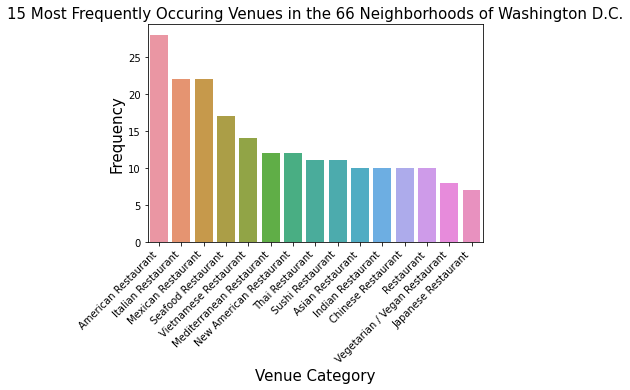

<Figure size 1296x504 with 0 Axes>

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=DC_restaurants_top)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('15 Most Frequently Occuring Venues in the 66 Neighborhoods of Washington D.C.', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

In [15]:
#Group the restaurants by neighborhood
DC_venues_restaurant = DC_restaurants.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
DC_venues_restaurant

Neighborhood
Adams Morgan                 13
Anacostia                     1
Bloomingdale                  4
Brightwood                    3
Brookland                     6
Burrville                     1
Cathedral Heights             2
Chinatown                    14
Cleveland Park                8
Columbia Heights              8
Congress Heights              1
Downtown                      1
Dupont Circle                10
Eckington                     4
Federal Triangle              4
Foggy Bottom                  6
Friendship Heights            7
Georgetown                    6
Glover Park                   8
Golden Triangle               5
Ivy City                      8
Judiciary Square             14
Kingman Park                  1
LeDroit Park                  6
Logan Circle                  8
Manor Park                    2
Marshall Heights              1
Michigan Park                 1
Mount Pleasant               12
Mount Vernon Square          13
Navy Yard                  

In [16]:
restaurant_df  = DC_venues_restaurant.to_frame().reset_index()
restaurant_df.columns = ['Neighborhood', 'Number of Restaurants']
restaurant_df.index = np.arange(1, len(restaurant_df)+1)
list_rest_no = restaurant_df['Number of Restaurants'].to_list()
list_dist = restaurant_df['Neighborhood'].to_list()

#Do one hot encoding to help find the frequency of restaurants
DC_onehot = pd.get_dummies(DC_restaurants[['Venue Category']], prefix="", prefix_sep="")

#add neighborhood column back to dataframe
DC_onehot['Neighborhood'] = DC_restaurants['Neighborhood'] 

#move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

DC_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Dumpling Restaurant,Eastern European Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
1,Adams Morgan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adams Morgan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adams Morgan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adams Morgan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Adams Morgan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
DC_onehot.shape

(289, 45)

In [18]:
#Group the rows by neighborhood and find the mean of the of the frequency of occurence for each category
DC_grouped = DC_onehot.groupby('Neighborhood').mean().reset_index()
DC_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Dumpling Restaurant,Eastern European Restaurant,...,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant
0,Adams Morgan,0.076923,0.000000,0.153846,0.076923,0.000000,0.000000,0.000000,0.000,0.076923,...,0.000000,0.000000,0.000000,0.076923,0.000000,0.00,0.000000,0.000000,0.000000,0.000
1,Anacostia,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000
2,Bloomingdale,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000
3,Brightwood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000,0.000000,...,0.000000,0.333333,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000
4,Brookland,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.166667,0.000
5,Burrville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000
6,Cathedral Heights,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000
7,Chinatown,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.071429,0.000000,0.714286,0.000
8,Cleveland Park,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.000000,0.125
9,Columbia Heights,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.000000,0.000000,0.000


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
#Arrange and display the 15 most common restaurants in each neighborhood
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped['Neighborhood']

for ind in np.arange(DC_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Adams Morgan,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
1,Anacostia,American Restaurant,Xinjiang Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
2,Bloomingdale,Asian Restaurant,Mexican Restaurant,Caribbean Restaurant,Italian Restaurant,Xinjiang Restaurant,Fast Food Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Ethiopian Restaurant,Falafel Restaurant,Empanada Restaurant
3,Brightwood,Mexican Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Xinjiang Restaurant,Falafel Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Empanada Restaurant,Ethiopian Restaurant,Italian Restaurant
4,Brookland,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [21]:
kclusters = 6

DC_grouped_clustering = DC_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(DC_grouped_clustering)

kmeans.labels_[0:10] 

array([3, 1, 3, 3, 1, 0, 1, 4, 3, 1], dtype=int32)

In [22]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DC_merged = DC_restaurants
DC_merged = DC_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
DC_merged.drop('Venue Category',axis = 1, inplace = True)

In [23]:
DC_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,...,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,Adams Morgan,38.9215,-77.042199,Lapis,38.921302,-77.043890,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,...,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
2,Adams Morgan,38.9215,-77.042199,Donburi,38.921673,-77.042385,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,...,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
3,Adams Morgan,38.9215,-77.042199,Tail Up Goat,38.923522,-77.043099,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,...,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
4,Adams Morgan,38.9215,-77.042199,Amsterdam Falafelshop,38.921162,-77.041959,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,...,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
5,Adams Morgan,38.9215,-77.042199,Mintwood Place,38.922053,-77.043611,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,...,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant


In [24]:
# create map
map_restaurants = folium.Map(location=[latitude,longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(DC_merged['Neighborhood Latitude'], 
                                  DC_merged['Neighborhood Longitude'], 
                                  DC_merged['Neighborhood'], 
                                  DC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_restaurants)
       
map_restaurants

In [25]:
DC_merged.loc[DC_merged['Cluster Labels'] == 0, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]


,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
28,38.901537,-76.923880,0,Seafood Restaurant,Xinjiang Restaurant,Ethiopian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant,Dumpling Restaurant
195,38.902759,-77.002155,0,Restaurant,Indian Restaurant,Seafood Restaurant,Xinjiang Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant
196,38.902759,-77.008071,0,Restaurant,Indian Restaurant,Seafood Restaurant,Xinjiang Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant
197,38.902759,-77.002312,0,Restaurant,Indian Restaurant,Seafood Restaurant,Xinjiang Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant
225,38.870395,-76.970293,0,Chinese Restaurant,Seafood Restaurant,Xinjiang Restaurant,Ethiopian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant
226,38.870395,-76.966250,0,Chinese Restaurant,Seafood Restaurant,Xinjiang Restaurant,Ethiopian Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Italian Restaurant,Eastern European Restaurant
288,38.931229,-76.973856,0,Restaurant,Chinese Restaurant,Xinjiang Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Italian Restaurant,Empanada Restaurant,Eastern European Restaurant
289,38.931229,-76.974053,0,Restaurant,Chinese Restaurant,Xinjiang Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Italian Restaurant,Empanada Restaurant,Eastern European Restaurant


In [26]:
DC_merged.loc[DC_merged['Cluster Labels'] == 1, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
14,38.862581,-76.984969,1,American Restaurant,Xinjiang Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
22,38.933130,-76.997640,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
23,38.933130,-76.991132,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
24,38.933130,-76.996451,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
25,38.933130,-76.990938,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
26,38.933130,-76.990839,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
27,38.933130,-76.991175,1,American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Indian Restaurant,Vietnamese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Israeli Restaurant,Asian Restaurant,Greek Restaurant,Brazilian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
29,38.934578,-77.085034,1,Italian Restaurant,American Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
30,38.934578,-77.085150,1,Italian Restaurant,American Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
53,38.961515,-77.087468,1,American Restaurant,Italian Restaurant,Sushi Restaurant,Mediterranean Restaurant,Mexican Restaurant,Falafel Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Israeli Restaurant


In [27]:
DC_merged.loc[DC_merged['Cluster Labels'] == 2, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
61,38.842897,-76.996879,2,Fast Food Restaurant,Xinjiang Restaurant,Vietnamese Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant
135,38.898004,-76.974422,2,Fast Food Restaurant,Xinjiang Restaurant,Vietnamese Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant
153,38.946984,-76.993315,2,Fast Food Restaurant,Xinjiang Restaurant,Vietnamese Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant


In [28]:
DC_merged.loc[DC_merged['Cluster Labels'] == 3, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]


,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
1,38.921500,-77.043890,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
2,38.921500,-77.042385,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
3,38.921500,-77.043099,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
4,38.921500,-77.041959,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
5,38.921500,-77.043611,3,Asian Restaurant,Mediterranean Restaurant,Japanese Restaurant,New American Restaurant,Brazilian Restaurant,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Italian Restaurant,Afghan Restaurant,Sushi Restaurant,Seafood Restaurant,Tex-Mex Restaurant,French Restaurant,Filipino Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,38.925025,-77.051050,3,Sushi Restaurant,Mediterranean Restaurant,Afghan Restaurant,New American Restaurant,Portuguese Restaurant,Italian Restaurant,Cajun / Creole Restaurant,American Restaurant,Caribbean Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Asian Restaurant
284,38.925025,-77.052011,3,Sushi Restaurant,Mediterranean Restaurant,Afghan Restaurant,New American Restaurant,Portuguese Restaurant,Italian Restaurant,Cajun / Creole Restaurant,American Restaurant,Caribbean Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Asian Restaurant
285,38.925025,-77.051908,3,Sushi Restaurant,Mediterranean Restaurant,Afghan Restaurant,New American Restaurant,Portuguese Restaurant,Italian Restaurant,Cajun / Creole Restaurant,American Restaurant,Caribbean Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Asian Restaurant
286,38.925025,-77.052286,3,Sushi Restaurant,Mediterranean Restaurant,Afghan Restaurant,New American Restaurant,Portuguese Restaurant,Italian Restaurant,Cajun / Creole Restaurant,American Restaurant,Caribbean Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Asian Restaurant


In [29]:
DC_merged.loc[DC_merged['Cluster Labels'] == 4, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
31,47.602038,-122.316938,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
32,47.602038,-122.317891,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
33,47.602038,-122.315298,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
34,47.602038,-122.317519,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
35,47.602038,-122.317826,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
36,47.602038,-122.315370,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
37,47.602038,-122.320228,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
38,47.602038,-122.319080,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
39,47.602038,-122.316680,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant
40,47.602038,-122.314686,4,Vietnamese Restaurant,Ethiopian Restaurant,Thai Restaurant,Asian Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Xinjiang Restaurant,Italian Restaurant


In [30]:
DC_merged.loc[DC_merged['Cluster Labels'] == 5, DC_merged.columns[[1] + list(range(5, DC_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
62,47.392421,-122.231672,5,Chinese Restaurant,Xinjiang Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
152,38.886314,-76.925637,5,Chinese Restaurant,Xinjiang Restaurant,Falafel Restaurant,Israeli Restaurant,Indian Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Vietnamese Restaurant,Empanada Restaurant,Eastern European Restaurant
